<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Nombre y apellidos:</strong>
</div>

Daniel Bagan Martínez

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve, GridSearchCV
import seaborn as sns
%matplotlib inline

## 1. Carga del conjunto de datos

Features: El dataset contiene 8 features en 8 columnas que son los parámetros medidos por los diferentes sensores. Estos corresponden a las diferentes interacciones que han tenido los haces de los láseres al travesar las partículas del aire.

Target: El target corresponde al 'label' que clasifica la calidad del aire.
- Target 0 corresponde a una calidad del aire Buena
- Target 1 corresponde a una calidad del aire Moderada
- Target 2 corresponde a una calidad del aire Peligrosa

In [2]:
# Creamos el dataframe a partir de .csv
df = pd.read_csv('uoc_train.csv')
df_test = pd.read_csv('uoc_X_test.csv')

# Mostramos número de filas y columnas
print("Filas train: " + str(df.shape[0]) + " Cols train: " + str(df.shape[1]))
print("Filas test: " + str(df_test.shape[0]) + " Cols test: " + str(df_test.shape[1]))

# Mostramos las primeras filas
df.head(5)

Filas train: 2100 Cols train: 9
Filas test: 900 Cols test: 8


,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,target
0,-0.458258,-0.579012,2.886009,-0.075516,1.674060,-2.431912,0.534850,-0.846473,2
1,1.626615,-0.028332,-1.443184,-1.007447,-0.989093,1.202627,-0.038211,-1.298616,0
2,1.721356,-0.137676,-1.322593,-1.333187,-0.723713,0.843285,-0.588495,0.066682,0
3,-0.715103,3.265915,-0.791030,-2.967881,2.497628,-0.277387,-0.551611,0.668354,2
4,2.944098,0.197871,-2.257025,1.032789,-4.104693,4.716115,-0.380813,-1.393825,0


In [3]:
# Descripción analítica básica del dataframe
df.describe()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,target
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,-0.318846,0.005348,-0.327567,0.024042,0.085851,-0.065000,-0.025603,-0.004437,0.985238
std,1.575061,1.605428,1.479745,1.548154,1.788543,2.124337,1.015619,1.003342,0.815098
min,-5.031501,-6.004578,-5.470794,-5.296172,-5.719499,-4.910575,-3.850552,-3.541608,0.000000
25%,-1.406249,-1.119150,-1.368208,-1.083716,-1.136441,-1.613267,-0.701442,-0.659096,0.000000
50%,-0.431219,-0.162577,-0.532158,0.152545,0.102788,-0.431328,-0.007598,-0.019797,1.000000
75%,0.773896,1.127450,0.573801,1.173172,1.507492,1.162813,0.665932,0.667530,2.000000
max,5.388387,7.663112,4.869581,4.318758,6.033273,7.053420,4.400697,3.579874,2.000000


<!-- ## Representación de variables y detección de outliers -->

## Visualización y detección de outliers

El siguiente histograma muestra que cada una de las tres posibles etiquetas contiene aproximadamente 1/3 del total.

<AxesSubplot:>

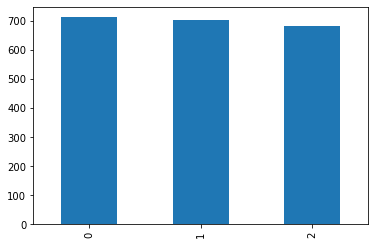

In [4]:
# Histograma con la etiqueta "target"
df['target'].value_counts().plot(kind='bar')

In [5]:
print("Target 0: {0}%".format(round(len(df[df['target']==0])/len(df)*100,2)))
print("Target 1: {0}%".format(round(len(df[df['target']==1])/len(df)*100,2)))
print("Target 2: {0}%".format(round(len(df[df['target']==2])/len(df)*100,2)))

Target 0: 33.95%
Target 1: 33.57%
Target 2: 32.48%


Los siguientes diagramas de cajas muestran la distribución de los valores de cada atributo. Aparentemente, no existen outliers en ninguno de los 8 atributos de entrada.

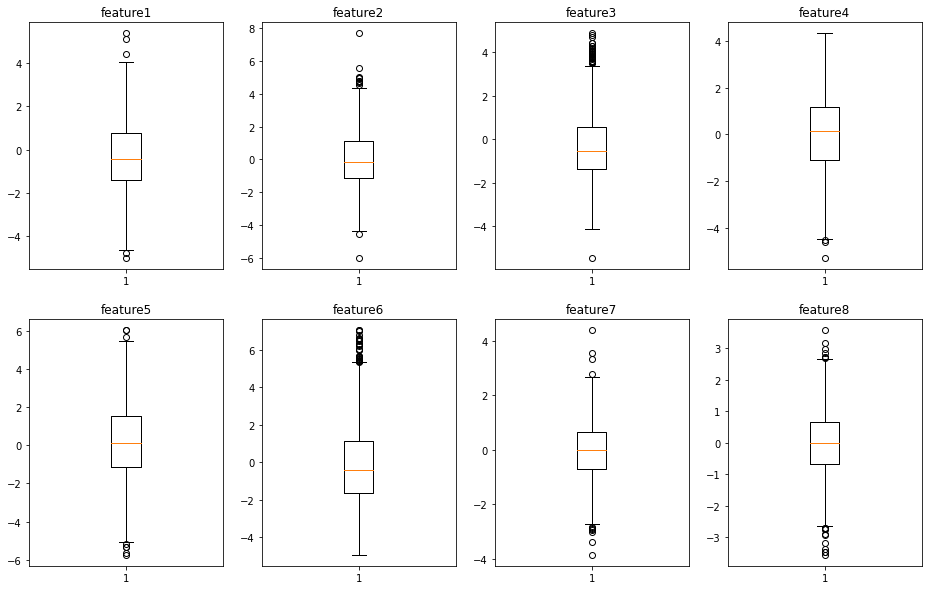

In [6]:
keys = df_test.keys()
f, ax = plt.subplots(2, 4,figsize=(16, 10))
for f in range(len(keys)):
    j=f%4
    i=f//4
    ax[i][j].boxplot(df[keys[f]])
    ax[i][j].set_title(keys[f])

Los siguientes histogramas muestran la distribución de la frecuencia valores de cada atributo. Las 8 atributos contienen muestras cercanas a una distribución normal.

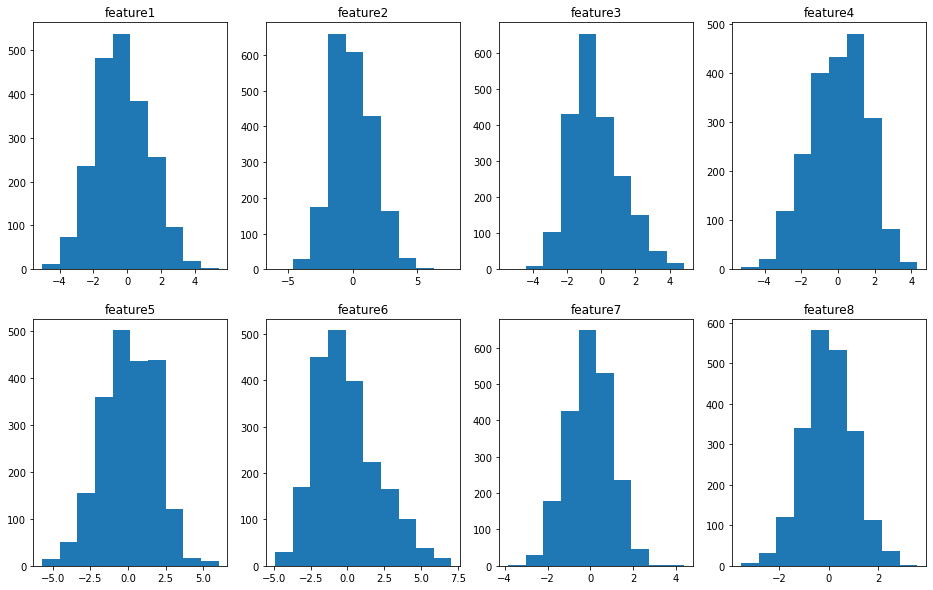

In [7]:
f, ax = plt.subplots(2, 4,figsize=(16, 10))
for f in range(len(keys)):
    j=f%4
    i=f//4
    ax[i][j].hist(df[keys[f]])
    ax[i][j].set_title(keys[f])

De la siguiente matriz de correlaciones podemos extraer las siguientes conclusiones:
- Las correlación de las **features 4, 7 y 8** con la etiqueta es muy débil, casi inexistente, por lo que **se puede valorar eliminar estas columnas**.
- La **feature 6** tiene casi un **-0.7** de correlación con la etiqueta, mientras la de las **features 3 y 5** es cercana a **0.6** y la **feature 5** es de aproximadamente **-0.5**, por tanto se tratan de **columnas con una correlación fuerte con la etiqueta**.
- Otras correlaciones que llaman la atención son el **-0.85** entre las **features 5 y 6**, o otras correlaciones fuertes como las existentes entre la **feature 1 con la 5 y la 6**. 
- En general podemos encontrar **correlaciones bastante fuertes** entre los atributos, por lo que quizás un **PCA** pueda reducir el número de variables sin perder varianza.


<AxesSubplot:>

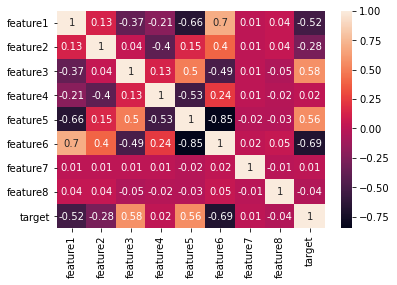

In [8]:
sns.heatmap(df.corr().round(2),annot=True)

A continuación, representaremos algunos gráficos en función de la etiqueta, para buscar posibles correlaciones menos evidentes.

Los siguientes diagramas de cajas añaden la diferenciación por clases, y cada caja representa al conjunto de valores con una etiqueta.
- Al igual que en la matriz de correlaciones, las features **4, 7 y 8** parecen ser las **menos útiles** a la hora de distinguir entre las etiquetas
- En las **features 1 y 6** se observa que el **aire con buena calidad** contiene, en general, **valores mayores**. 
- Para la **feature 3**, el aire de mala calidad tiene, en general, **valores mayores**.
- Los valores de la **feature 5** tienden a crecer conforme mejora la calidad del aire, al contrario que los de la **feature 6**, que tienden a decrecer.

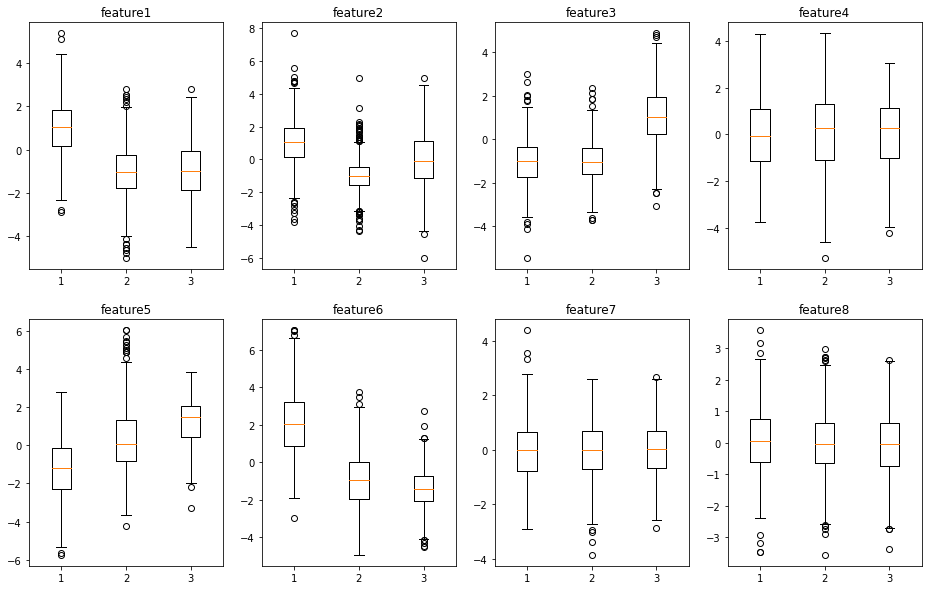

In [9]:
f, ax = plt.subplots(2, 4,figsize=(16, 10))
for f in range(len(keys)):
    j=f%4
    i=f//4
    data = [df[df['target']==0][keys[f]],df[df['target']==1][keys[f]],df[df['target']==2][keys[f]]]
    ax[i][j].boxplot(data)
    ax[i][j].set_title(keys[f])

Los siguientes histogramas y muestran la distribución de frecuencias de cada feature según la clase a la que pertenecen. Estos histogramas no permiten sacar ninguna conclusión adicional a las ya extraídas, más allá de que los registros pertenecientes a cada clase de cada feature también parecen seguir una distribución normal.

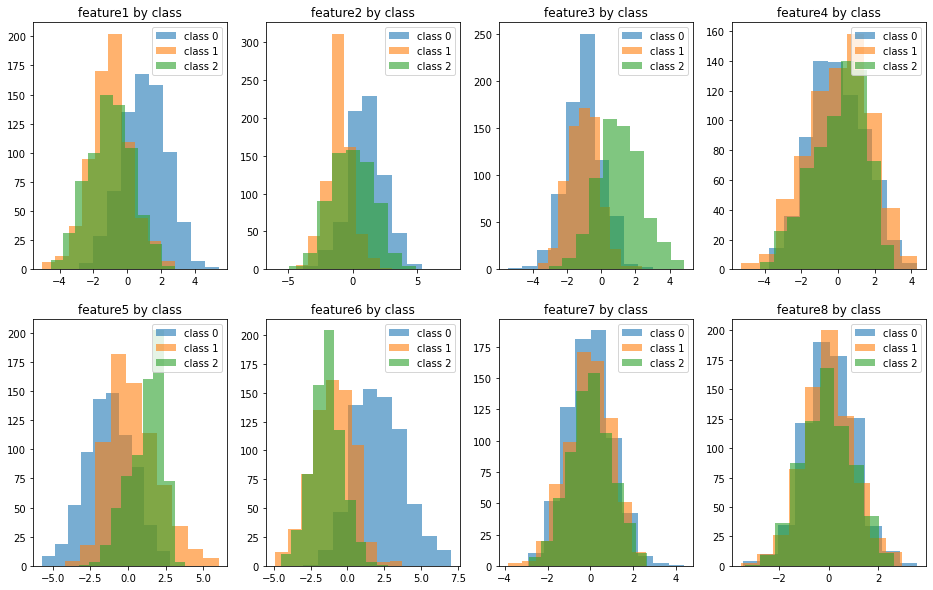

In [10]:
f, ax = plt.subplots(2, 4,figsize=(16, 10))
for f in range(len(keys)):
    j=f%4
    i=f//4
    for t in range(3):
        df_class = df[df["target"]==t]
        ax[i][j].hist(df_class[keys[f]], alpha=0.6, label="class " + str(t))
    ax[i][j].set_title(keys[f]+" by class")
    ax[i][j].legend(loc='upper right')  

## Creación del modelo

A continuación, procedemos a crear el modelo *Random Forest*. No se aplicará normalización, ya que no procede para la creación de los árboles de decisión.

En primer lugar se creará un modelo con todas las variables, en segundo lugar se creará eliminando aquellas que no parecen tener efecto alguna sobre la etiqueta a predecir, por su baja correlación, y finalmente se utilizará PCA para reducir el conjunto de datos, debido a las altas correlaciones entre sus variables.

Para cada modelo, se aplicará la función *GridSearch* para encontrar los mejores hiperparámetros. Finalmente, se seleccionará la opción que mejor *F1 score* ha obtenido.

Para estas pruebas, no se utilizará un conjunto de prueba y entrenamiento, si no que se utilizará *Cross Validation*.

In [11]:
#Creamos el conjunto de entrenamiento y de prueba, aunque no será necesario utilizarlo por el momento.
X = df.drop("target",axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

### Modelo con todas las variables
En primer lugar, probaremos el modelo sin eliminar columnas ni modificar el conjunto de datos. 

Se ha obtenido un **F1 score de 0.917**, con los **hiperparámetros** *max_depth=11* y *n_estimators=200*.

In [12]:
#Creamos nuestro propio f1 score para poder utilizarlo junto con GridSearchCV
f1 = make_scorer(f1_score , average='macro')

In [13]:
#Usamos GridSearch para encontrar la mejor combinación de parámetros, indicamos f1 como métrica
grid_params = {'n_estimators': [20,30,50,100,200],
               'max_depth': [3,4,5,6,7,8,9,10,11,12]}

gs = GridSearchCV(
    RandomForestClassifier(),
    grid_params,
    cv=4,
    n_jobs= -1,
    scoring=f1,
)

In [14]:
gs_results = gs.fit(X,y)

In [15]:
print("F1 score: " + str(gs_results.best_score_))
print(gs_results.best_estimator_)
print(gs_results.best_params_)

F1 score: 0.9169852008776329
RandomForestClassifier(max_depth=11, n_estimators=200)
{'max_depth': 11, 'n_estimators': 200}


<AxesSubplot:xlabel='param_n_estimators', ylabel='param_max_depth'>

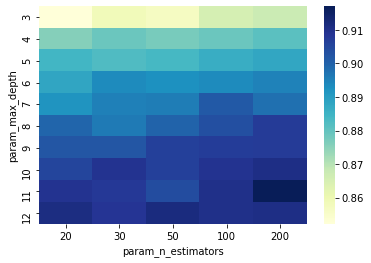

In [16]:
mat = pd.pivot_table(pd.DataFrame(gs_results.cv_results_),
                    values='mean_test_score', index='param_max_depth', columns='param_n_estimators')
sns.heatmap(mat, cmap="YlGnBu")

### Modelo sin las features 4, 7 y 8
A continuación, pasamos a eliminar las features que cuya correlación con el target es casi inexistente.

El F1 score del modelo no ha mejorado, de hecho, ha empeorado ligeramente a 0.908, con los mismo hiperparámetros que el modelo anterior.

In [17]:
#Creamos el conjunto de entrenamiento y de prueba
X2 = df.drop(["target","feature4","feature7","feature8"],axis=1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [18]:
gs_results = gs.fit(X_train,y_train)

In [19]:
print("F1 score: " + str(gs_results.best_score_))
print(gs_results.best_estimator_)
print(gs_results.best_params_)

F1 score: 0.908263415502417
RandomForestClassifier(max_depth=11, n_estimators=200)
{'max_depth': 11, 'n_estimators': 200}


<AxesSubplot:xlabel='param_n_estimators', ylabel='param_max_depth'>

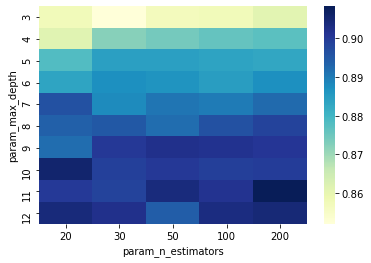

In [20]:
mat = pd.pivot_table(pd.DataFrame(gs_results.cv_results_),
                    values='mean_test_score', index='param_max_depth', columns='param_n_estimators')
sns.heatmap(mat, cmap="YlGnBu")

### Modelo con todas las features y PCA
Finalmente, procedemos a aplicar PCA para reducir la dimensionalidad del conjunto.

El modelo tampoco ha mejorado respecto al primero.

In [21]:
#Antes de aplicar PCA, se escalan todos los atributos usando StandardScaler:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [22]:
from sklearn.decomposition import PCA

# Cogeremos los 6 primeros componentes principales
pca = PCA(n_components=6)

pca.fit(X_scaled)

# se tranforman los datos en los dos primeros componentes principales
X_pca = pca.transform(X_scaled)

print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

#X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=24)


Original shape: (2100, 8)
Reduced shape: (2100, 6)


In [23]:
gs_results = gs.fit(X_pca,y)

In [24]:
print("F1 score: " + str(gs_results.best_score_))
print(gs_results.best_estimator_)
print(gs_results.best_params_)

F1 score: 0.9032153684923663
RandomForestClassifier(max_depth=11, n_estimators=20)
{'max_depth': 11, 'n_estimators': 20}


<AxesSubplot:xlabel='param_n_estimators', ylabel='param_max_depth'>

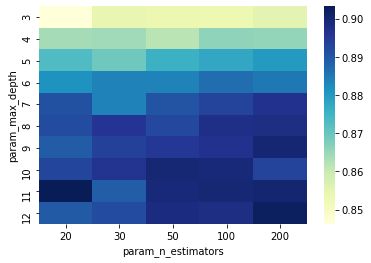

In [25]:
mat = pd.pivot_table(pd.DataFrame(gs_results.cv_results_),
                    values='mean_test_score', index='param_max_depth', columns='param_n_estimators')
sns.heatmap(mat, cmap="YlGnBu")

## Modelo final

Debido a que los mejores resultado que hemos obtenido los hemos conseguido con todos los atributos y unos hiperparámetros de max_depth=11, y n_estimators=200, procedemos a crear el modelo final.

In [30]:
X = df.drop("target",axis=1)
y = df["target"]

In [33]:
modelo = RandomForestClassifier(max_depth=11, n_estimators=200)
modelo.fit(X, y)
y_pred = modelo.predict(df_test)

In [35]:
y_pred

array([0, 2, 1, 0, 2, 1, 2, 0, 1, 1, 0, 1, 1, 1, 2, 2, 2, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 2, 0, 1, 2, 1, 2, 0, 0, 2, 1, 0, 1, 1, 2, 1,
       2, 0, 0, 0, 1, 2, 2, 0, 1, 0, 0, 2, 0, 2, 2, 0, 1, 0, 2, 0, 1, 0,
       1, 2, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 1, 2, 2, 2, 1, 2, 0, 0, 2,
       0, 1, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2, 0, 0, 0, 2, 0, 2, 2, 1, 0, 1,
       2, 0, 1, 2, 2, 1, 2, 2, 1, 0, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       2, 0, 0, 1, 2, 0, 0, 2, 0, 2, 2, 1, 0, 2, 1, 2, 1, 2, 1, 1, 1, 2,
       0, 2, 1, 1, 2, 1, 0, 1, 2, 1, 0, 2, 0, 2, 1, 0, 1, 1, 0, 2, 0, 2,
       2, 0, 1, 2, 1, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 1, 2, 2, 0, 2, 2,
       1, 1, 0, 2, 2, 2, 1, 2, 2, 1, 0, 2, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 2, 2, 1, 1, 1, 2, 0, 0, 2, 1, 2, 0, 1, 2, 2, 2, 0, 2,
       2, 0, 1, 0, 0, 0, 1, 2, 1, 2, 1, 2, 1, 0, 0, 1, 1, 2, 1, 2, 0, 2,
       1, 2, 0, 2, 0, 1, 1, 2, 1, 2, 1, 0, 0, 2, 1, 2, 1, 1, 1, 0, 1, 2,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 2, 0, 2, 1,

In [44]:
pd.DataFrame(y_pred).to_csv("predicciones.csv",index=False, header=['final_status'])